In [43]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import time
from einops import rearrange
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from utils import Metric,get_model_size,test_speed, set_logger,init_weights,set_seed, save_checkpoint, load_checkpoint
from models.KANFormer import KANFormer
from utils import get_model_size
from data import ChikuseiDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Data
import rasterio
import spectral

# Specify the path to the ENVI data file and the file with .hdr
file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.bsq'
header_file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.hdr'

# Open the ENVI image using rasterio
with rasterio.open(file) as src:
    # Read the hyperspectral data into a NumPy array
    print("Reading HS data")
    hyperspectral_data = src.read()

    # Display information about the hyperspectral data
    print('Shape of hyperspectral data:', hyperspectral_data.shape)
    print('Number of bands:', src.count)

Reading HS data
Shape of hyperspectral data: (128, 2517, 2335)
Number of bands: 128


In [5]:
#Open the image with spectral
header_spectral = spectral.open_image(header_file)

# Access the wavelengths associated with each band
w_vector = np.array(header_spectral.bands.centers)

# Display information about the hyperspectral data and wavelengths
print('Shape of hyperspectral data:', header_spectral.shape)
print('Number of bands:', header_spectral.shape[2])
print('Wavelengths:', w_vector)

Shape of hyperspectral data: (2517, 2335, 128)
Number of bands: 128
Wavelengths: [0.36259 0.36775 0.3729  0.37807 0.38323 0.38839 0.39355 0.39871 0.40387
 0.40903 0.41419 0.41936 0.42452 0.42968 0.43484 0.44    0.44516 0.45032
 0.45548 0.46064 0.4658  0.47096 0.47612 0.48129 0.48645 0.49161 0.49677
 0.50193 0.50709 0.51225 0.51741 0.52257 0.52773 0.53289 0.53806 0.54321
 0.54838 0.55354 0.5587  0.56386 0.56902 0.57418 0.57934 0.5845  0.58966
 0.59483 0.59999 0.60514 0.61031 0.61547 0.62063 0.62579 0.63095 0.63611
 0.64127 0.64643 0.65159 0.65675 0.66192 0.66707 0.67224 0.6774  0.68256
 0.68772 0.69288 0.69804 0.7032  0.70836 0.71352 0.71868 0.72385 0.72901
 0.73417 0.73933 0.74449 0.74965 0.75481 0.75997 0.76513 0.77029 0.77545
 0.78061 0.78578 0.79094 0.7961  0.80126 0.80642 0.81158 0.81674 0.8219
 0.82706 0.83223 0.83738 0.84254 0.84771 0.85287 0.85803 0.86319 0.86835
 0.87351 0.87867 0.88383 0.88899 0.89416 0.89931 0.90448 0.90964 0.9148
 0.91996 0.92512 0.93028 0.93544 0.9406  0.94

In [6]:
full_image = rearrange(hyperspectral_data,'c h w -> h w c')
chikusei_data = ChikuseiDataset(full_image=full_image,training_zone=[128,128,1024,1024],wave_vector=w_vector,scale=4,gt_size=64)

In [7]:
img1 = chikusei_data[10][2].reshape((64,64,4))[:,:,0]
lr1 = chikusei_data[10][1].reshape((16,16,128))[:,:,0]
gt1 = chikusei_data[12][0][45]
print(np.max(img1.numpy()))
print(np.max(gt1.numpy()))
print(np.max(lr1.numpy()))
gt1, img1, lr1

1.0
1.0
1.0


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 1.]]),
 tensor([[0.0506, 0.0602, 0.1280,  ..., 0.0375, 0.0059, 0.0176],
         [0.0512, 0.0601, 0.1321,  ..., 0.0073, 0.0164, 0.0437],
         [0.0514, 0.0599, 0.1347,  ..., 0.0121, 0.0443, 0.0618],
         ...,
         [0.1148, 0.0888, 0.0128,  ..., 0.0983, 0.1562, 0.2090],
         [0.1142, 0.0880, 0.0150,  ..., 0.0983, 0.2144, 0.3087],
         [0.1213, 0.1031, 0.0400,  ..., 0.1040, 0.3986, 0.5072]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

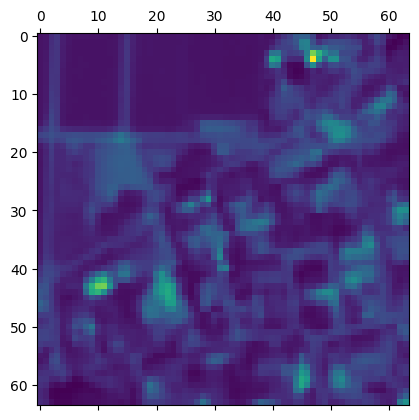

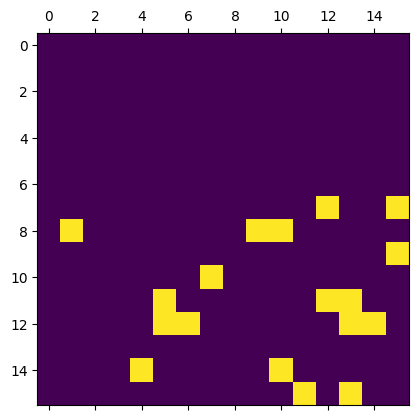

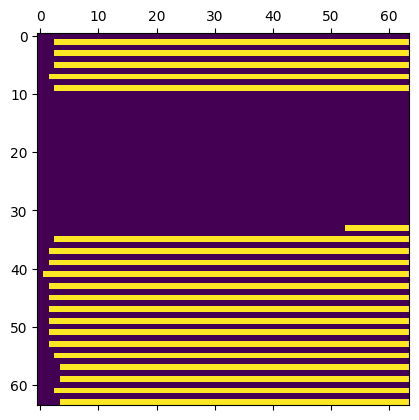

In [8]:
plt.matshow(img1)
plt.matshow(lr1)
plt.matshow(gt1)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.cuda.empty_cache()

# Model
HSI_bands = full_image.shape[2]
MSI_bands = 4
chikusei_KAN = KANFormer(HSI_bands=HSI_bands,MSI_bands=MSI_bands,hidden_dim=256,scale=4,depth=4,image_size=64)
chikusei_KAN = chikusei_KAN.to(device)

# Training params
start_epoch = 0
epochs = 1000
batch_size = 8
lr = 4e-4
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(lr=lr,params=chikusei_KAN.parameters())
scheduler = StepLR(optimizer=optimizer,step_size=100,gamma=0.1)

full_image = rearrange(hyperspectral_data,'c h w -> h w c')
chikusei_data = ChikuseiDataset(full_image=full_image,training_zone=[128,128,1024,1024],wave_vector=w_vector,scale=4,gt_size=64)
train_dataloader = DataLoader(chikusei_data,batch_size=batch_size,drop_last=True,shuffle=True)

model_name = 'KANFormer'
scale = 4
dataset = 'chikusei'

# Logs
# inference_time,flops,params = test_speed(chikusei_KAN,device,HSI_bands,scale=scale,channels=MSI_bands)
# now = str(datetime.now().replace(minute=0,second=0,microsecond=0)) # current date and time
# log_dir = f'./trained_models/{model_name}_x{scale}_{dataset},{now}'
# log_out = 1
# if not os.path.exists(log_dir) and log_out == 1:
#         os.mkdir(log_dir)
# logger = set_logger(model_name, log_dir, log_out)
# model_size = get_model_size(chikusei_KAN)
# logger.info(f'[model:{model_name}_x{scale},dataset:{dataset}],model_size:{params}M,inference_time:{inference_time:.6f}S,FLOPs:{flops}G')


4
4


In [11]:
chikusei_KAN.eval()
random_lr_hs = np.random.random((1,128,16,16))
random_hr_ms = np.random.random((1,4,64,64))
random_lr_hs_torch = torch.tensor(random_lr_hs, device=device, dtype=torch.float32)
random_hr_ms_torch = torch.tensor(random_hr_ms, device=device, dtype=torch.float32)


In [12]:
output = chikusei_KAN(random_lr_hs_torch,random_hr_ms_torch)

Forward pass


In [13]:
output.cpu().detach().numpy()

array([[[[0.58479834, 0.47493052, 0.31595758, ..., 0.6831483 ,
          0.662654  , 0.6312402 ],
         [0.47828794, 0.38147062, 0.2521135 , ..., 0.68412435,
          0.6659681 , 0.63945967],
         [0.33993036, 0.26532668, 0.17832048, ..., 0.69505984,
          0.6707318 , 0.64560145],
         ...,
         [0.6571344 , 0.6205944 , 0.6061801 , ..., 0.48418334,
          0.23289572, 0.0335471 ],
         [0.77733636, 0.674221  , 0.54900444, ..., 0.5137949 ,
          0.25266072, 0.06426806],
         [0.88924736, 0.7275003 , 0.5264589 , ..., 0.5343593 ,
          0.28905886, 0.07195625]],

        [[0.8047814 , 0.7043383 , 0.56740266, ..., 0.6760142 ,
          0.8398319 , 0.98065275],
         [0.8171942 , 0.6791743 , 0.51914114, ..., 0.5716068 ,
          0.6888037 , 0.8032941 ],
         [0.8336161 , 0.67368996, 0.47144482, ..., 0.44709587,
          0.5272712 , 0.60646814],
         ...,
         [0.16166452, 0.27928346, 0.41776937, ..., 0.530503  ,
          0.3509115 , 0.2

In [14]:
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.max_memory_allocated())
print(torch.cuda.memory_allocated()) # Memory allocated
print(torch.cuda.memory_reserved())  # Total memory reserved in the CUDA pool
print(torch.cuda.memory_summary(device=0, abbreviated=False))

8585216000
831279104
730226688
977272832
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 713112 KiB |    792 MiB |   2320 MiB |   1624 MiB |
|       from large pool | 704640 KiB |    785 MiB |   2297 MiB |   1608 MiB |
|       from small pool |   8472 KiB |      9 MiB |     23 MiB |     15 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 713112 KiB |    792 MiB |   2320 MiB |   1624 MiB |
|       from large pool

In [53]:
def train(epochs: int,model: torch.nn.Module, checkpoint: str=None):

    if checkpoint is None:
        print("No checkpoint - starting training from scratch")
        init_weights(model)
        start_epoch = 0
        run = 1
        log_dir = f'./trained_models/{model.name}_x{model.scale}_{run}/'
        print(log_dir)
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

    if checkpoint is not None:
        print(f'check_point: {checkpoint}')
        cp = torch.load(checkpoint)
        model.load_state_dict(cp['model'],strict=False)  
        optimizer.load_state_dict(cp['optimizer']) 
        scheduler.load_state_dict(cp['scheduler'])
        start_epoch = cp['epoch']+1
        underscore_index = checkpoint.find('_')
        slash_index = checkpoint.find('/', underscore_index)  # Search for '/' after '_'
        if underscore_index != -1 and slash_index != -1:
            run = int(checkpoint[underscore_index + 1:slash_index])+1  # Extract the substring and increment by one
        log_dir = f'./trained_models/{model.name}_x{model.scale}_{run}/'
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

    print(log_dir+f'{model.name}_x{model.scale}_{run}_1.pth')

    model.train()
    hist_loss = { "batch_loss": [], "epoch_loss": []}
    training_start = time.time()
    for epoch in range(start_epoch, epochs):
        # start_time = time.time()
        print("Epoch: ", epoch)
        epoch_loss = 0
        filename = ""
        # Batch loop
        for idx,loader_data in enumerate(train_dataloader):
            GT,LRHSI,HRMSI = loader_data[0].to(device),loader_data[1].to(device),loader_data[2].to(device)
            preHSI = chikusei_KAN(LRHSI,HRMSI)
            loss = loss_func(GT,preHSI) #+chikusei_KAN.regularization_loss()
            print("Loss: ", loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Batch loss: ", loss.item())
            hist_loss["batch_loss"].append(loss.item())
        hist_loss["epoch_loss"].append(np.mean(hist_loss["batch_loss"]))
        # Save at the end of the epoch
        state = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': loss
            }        
        filename = log_dir+f'{model.name}_x{model.scale}_{run}_{epoch}.pth'
        print(filename)
        save_checkpoint(state, filename=filename)
        scheduler.step()
        # logging.info(f'Epoch:{epoch},loss:{np.mean(hist_loss["batch_loss"])},time:{time.time()-start_time:.2f}s')
    print(f"Training with batch size {train_dataloader.batch_size} for {epochs} epochs completed in {time.time()-training_start:.2f}s")

    return hist_loss

In [54]:
historic_loss = train(2,chikusei_KAN)

No checkpoint - starting training from scratch
./trained_models/KANFormer_x4_1/
./trained_models/KANFormer_x4_1/KANFormer_x4_1_1.pth
Epoch:  0
Loss:  0.1961267590522766
Batch loss:  0.1961267590522766
Loss:  0.28113067150115967
Batch loss:  0.28113067150115967
Loss:  0.23234090209007263
Batch loss:  0.23234090209007263
Loss:  0.28274351358413696
Batch loss:  0.28274351358413696
Loss:  0.2444438636302948
Batch loss:  0.2444438636302948
Loss:  0.3295131325721741
Batch loss:  0.3295131325721741
Loss:  0.29341015219688416
Batch loss:  0.29341015219688416
Loss:  0.22515372931957245
Batch loss:  0.22515372931957245
Loss:  0.38356438279151917
Batch loss:  0.38356438279151917
Loss:  0.2669408619403839
Batch loss:  0.2669408619403839
Loss:  0.21076181530952454
Batch loss:  0.21076181530952454
Loss:  0.24442127346992493
Batch loss:  0.24442127346992493
Loss:  0.14561447501182556
Batch loss:  0.14561447501182556
Loss:  0.30844253301620483
Batch loss:  0.30844253301620483
Loss:  0.1707770526409149

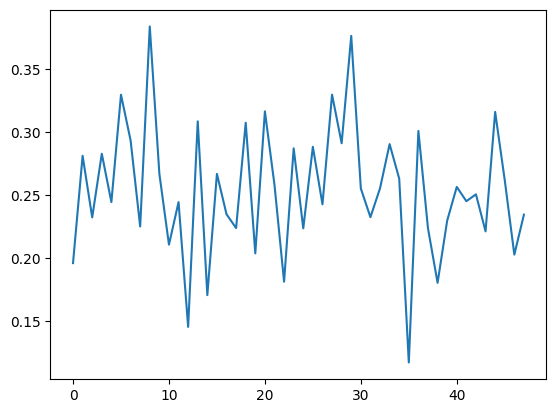

In [55]:
plt.plot(historic_loss["batch_loss"])
plt.show()

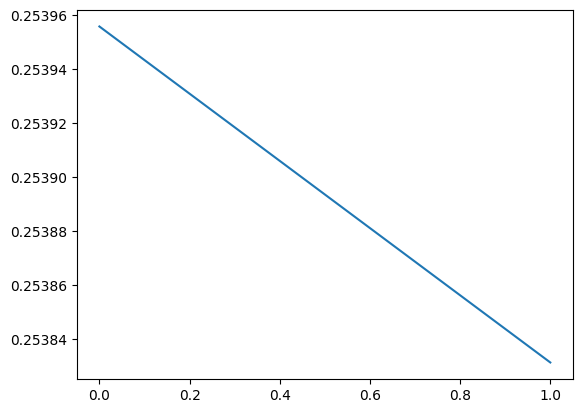

In [56]:
plt.plot(historic_loss["epoch_loss"])
plt.show()